In [2]:
from multiclass_functions1 import *
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import copy
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# !nvidia-smi # model 이 GPU에 잘 올라갔는지 확인 가능

cpu


In [13]:
L_save = False
NoB = 10
NoC = 1
activation = "BNReLU"
model_type = f"{activation}{NoB}C{NoC}"
save_Smodel_path = f"model_save/{model_type}_VG_MNIST.pt"
L_Smodel_path = "model_save/L_Smodel.pt"

NoB = 100 # BN하고 RELU도 했지만, 그냥 layer개수만 많이 한 것 > 그것의 원인 = loss landscape더라
NoC = 1
activation = "BNReLU"
model_type = f"{activation}{NoB}C{NoC}"
save_Dmodel_path = f"model_save/{model_type}_VG_MNIST.pt"
L_Dmodel_path = "model_save/L_Dmodel.pt"

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        if activation == "Sigmoid":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.Sigmoid(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.Sigmoid()]]
                )
        elif activation == "BNSigmoid":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.BatchNorm2d(NoC),
                nn.Sigmoid(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.BatchNorm2d(NoC), nn.Sigmoid()]]
                )
        elif activation == "ReLU":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.ReLU(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.ReLU()]]
                )
        elif activation == "BNReLU":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.BatchNorm2d(NoC),
                nn.ReLU(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.BatchNorm2d(NoC), nn.ReLU()]]
                )
        # self.fc = nn.Linear(NoC*(28-2*NoB)*(28-2*NoB),10, bias=False)
        self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(NoC*7*7,10, bias=False)

    def forward(self, x):
        x = self.conv_block(x)
        x = self.maxpool1(x)
        x = self.maxpool2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [10]:
def Test_load_model(loaded, load_model):
    BATCH_SIZE = loaded["BATCH_SIZE"]
    LR = loaded["LR"]
    EPOCH = loaded["EPOCH"]
    loss_history = loaded["loss_history"]
    acc_history = loaded["acc_history"]

    transform = transforms.ToTensor()
    train_DS = datasets.MNIST(root = '../data', train=True, download=True, transform=transform)
    test_DS = datasets.MNIST(root = '../data', train=False, download=True, transform=transform)
    train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
    test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

    test_acc = Test(load_model, test_DL)
    print(count_params(load_model))
    Test_plot(load_model, test_DL)

    fig, ax1 = plt.subplots(figsize=[8,5])
    ax2 = ax1.twinx()
    p1=ax1.plot(range(1,EPOCH+1),loss_history,'r')
    p2=ax2.plot(range(1,EPOCH+1),acc_history)
    ax1.set_xlim([-5,EPOCH+5])
    ax1.set_ylim([min(loss_history)*0.7, max(loss_history)*1.1])
    ax2.set_ylim([0, 100])
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("accuracy")
    ax1.set_title(f"Train Loss (Final Test accuracy = {test_acc} % with BS = {BATCH_SIZE} & LR = {LR})")
    ax1.grid()
    plt.legend(p1+p2,["loss","accuracy"], loc="right")

Test accuracy: 9517/10000 (95.2 %)
600
Test accuracy: 1189/10000 (11.9 %)
1590


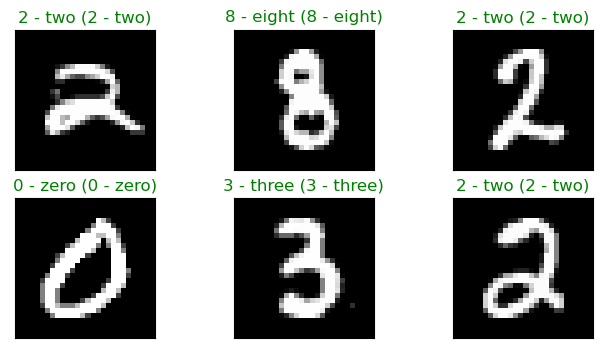

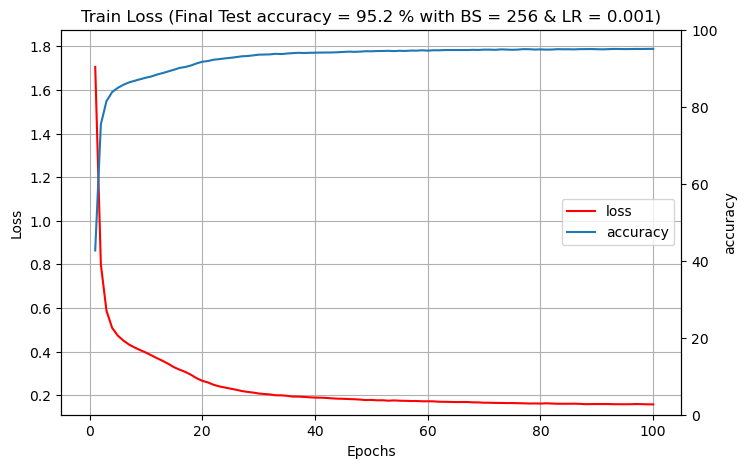

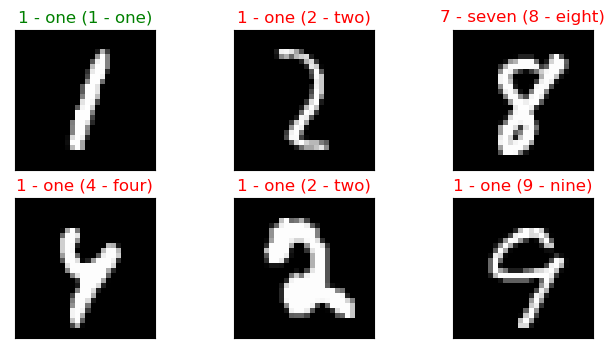

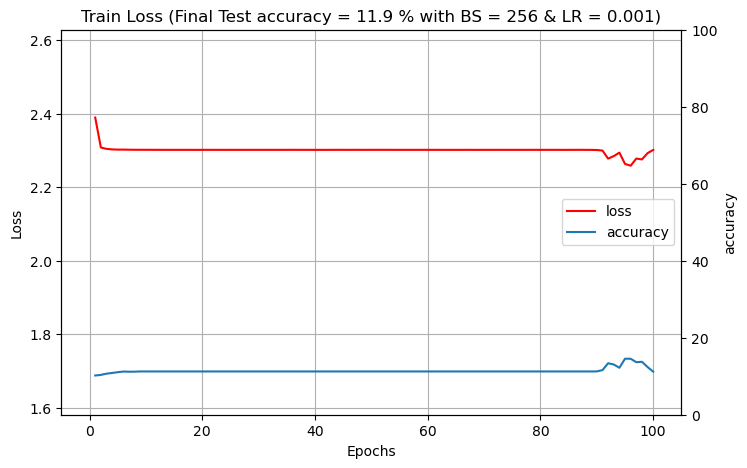

In [11]:
loaded_S = torch.load(save_Smodel_path, map_location=DEVICE)
load_Smodel = loaded_S["model"]
loaded_D = torch.load(save_Dmodel_path, map_location=DEVICE)
load_Dmodel = loaded_D["model"]

Test_load_model(loaded_S,load_Smodel)
Test_load_model(loaded_D,load_Dmodel)

똑같은 상황에서 layer만 늘렸는데, 학습이 잘 안되더라

In [12]:
def loss_small(model, DL, max_N):
    N = 0
    rloss = 0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            # inference
            y_hat = model(x_batch)
            # loss
            loss = F.cross_entropy(y_hat, y_batch)
            # loss accumulation
            loss_b = loss.item() * x_batch.shape[0]
            rloss += loss_b # running loss
            # # of Data
            N += x_batch.shape[0]
            if N > max_N:
                break
        loss = rloss/N

    return loss

# Loss landscape 논문 읽고 구현한 함수
def mat_norm(mat):
    if len(mat.shape) == 1:
        return torch.linalg.vector_norm(mat)
    else:
        return torch.linalg.vector_norm(torch.linalg.matrix_norm(mat))

def dir_gen(weight_list):
    eta_list=[]
    delta_list=[]
    for w in weight_list:
        eta=torch.tensor([]).to(DEVICE)
        delta=torch.tensor([]).to(DEVICE)
        for j in range(w.shape[0]):
            filter = w[j]
            e=torch.randn(filter.shape).to(DEVICE)
            d=torch.randn(filter.shape).to(DEVICE)
            e=e/mat_norm(e)
            d=d/mat_norm(d)
            eta = torch.cat([eta, (e*mat_norm(filter)).unsqueeze(dim=0)])
            delta = torch.cat([delta, (d*mat_norm(filter)).unsqueeze(dim=0)])
        eta_list += [eta]
        delta_list += [delta]

    return eta_list, delta_list

def weight_perturb(model,eta_list,delta_list,a,b):
    model.eval()
    with torch.no_grad():
        module_list = [m for m in model.modules() if isinstance(m,nn.Conv2d) or isinstance(m,nn.Linear)]
        for i, m in enumerate(module_list):
            m.weight += a*eta_list[i]
            m.weight += b*delta_list[i]

In [14]:
# loss landscape를 만드는 과정에서 생기는 새로운 파라미터들
a=torch.linspace(-1,1,31)
b=torch.linspace(-1,1,31)
A, B = torch.meshgrid(a,b)
max_N = 50000

/Users/lee/opt/anaconda3/envs/DL/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525474122/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [15]:
if L_save:
    Sweight_list = [m.weight.detach() for m in load_Smodel.modules() if isinstance(m,nn.Conv2d) or isinstance(m,nn.Linear)]
    Dweight_list = [m.weight.detach() for m in load_Dmodel.modules() if isinstance(m,nn.Conv2d) or isinstance(m,nn.Linear)]
    eta_Smodel, delta_Smodel = dir_gen(Sweight_list)
    eta_Dmodel, delta_Dmodel = dir_gen(Dweight_list)

    train_DS = datasets.MNIST(root = '/content/drive/MyDrive/Colab Notebooks/data', train=True, download=True, transform=transforms.ToTensor())
    train_DL_noshuffle = torch.utils.data.DataLoader(train_DS, batch_size=1024, shuffle=False)
    L_Smodel=torch.zeros(len(a),len(b))
    L_Dmodel=torch.zeros(len(a),len(b))
    for i in range(len(a)):
        for j in range(len(b)):
            Smodel_p = copy.deepcopy(load_Smodel)
            weight_perturb(Smodel_p,eta_Smodel,delta_Smodel,a[i],b[j])
            L_Smodel[i,j] = loss_small(Smodel_p,train_DL_noshuffle)
            Dmodel_p = copy.deepcopy(load_Dmodel)
            weight_perturb(Dmodel_p,eta_Dmodel,delta_Dmodel,a[i],b[j])
            L_Dmodel[i,j] = loss_small(Dmodel_p,train_DL_noshuffle)

    torch.save(L_Smodel,L_Smodel_path)
    torch.save(L_Dmodel,L_Dmodel_path)

In [ ]:
import plotly.graph_objects as go
L_load = torch.load("model_save/L_Smodel.pt", map_location=DEVICE)
fig = go.Figure(data=[go.Surface(x=a, y=b, z=L_load.cpu(), colorscale="viridis", opacity=0.5)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Loss Landscape', width=700, height=600,
                  scene = dict( zaxis=dict(nticks=30, range=[0,20]) ) )

<img src="image/loss_lands1.png" width="300">
<img src="image/loss_lands2.png" width="300">

In [ ]:
L_load = torch.load("model_save/L_Dmodel.pt", map_location=DEVICE)
fig = go.Figure(data=[go.Surface(x=a, y=b, z=L_load.cpu(), colorscale="viridis", opacity=0.5)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Loss Landscape', width=700, height=600,
                  scene = dict( zaxis=dict(nticks=10, range=[0,20]) ))

<img src="image/loss_lands_deep1.png" width="300">

모델이 학습했던 구간을 시각화한 것
- weight축으로 loss를 본 것
- 레이어가 10개인 곳은 그래도 min 잘 찾아서 움직인 것 같으나,
- 레이어가 100개인 건 학습을 제대로 진행하지 못한 것으로 보임 (잘 움직이지 못했다)

# 결과 확인

<img src="image/layer1_init.png" width="800">
<img src="image/layer1.png" width="800">

<img src="image/layer100_init.png" width="800">
<img src="image/layer100.png" width="800">

위 레이어 10개, 아래 레이어 100개
- 레이어 개수가 많아졌을 때, 동일한 조건 (BN & RELU)여도 학습이 제대로 되지 않는 것을 볼 수 있다
- 근데 vanishing gradient는 없어야 하는데?
  - <img src="image/vanishing_gradient_ex.png" width="200">
  - vanishing gradient 양상 > 점차 weight가 앞단의 레이어로 갈수록 줄어들어가는 것